In [1]:

import SimilarDB
import SongIndex
import TagDB


from scipy.spatial.distance import cosine
from scipy.spatial.distance import jaccard
import numpy as np

import pandas as pd

import json
import random



In [2]:
datapath = '/home/agonzales/million_songs/data/'

songs = SongIndex.SongIndex(datapath)

In [ ]:

sims = SimilarDB.SimilarDB(datapath)

In [14]:
tags = TagDB.TagDB(datapath)

In [5]:
def load_top_user_tracks(path):
    with open(path, 'r') as f:
        topsongs = json.load(f)
    return {thing['user']: thing['song'] for thing in json.loads(topsongs)}



In [6]:
topsong_path = './data/top_two_songs_dict.json'
users = load_top_user_tracks(topsong_path)

In [7]:
converter = lambda x: songs.getTrackIDs(x)

user_track_ids = lambda x: list(reduce(lambda y, acc: acc.union(y), map(converter, users[x])))

In [ ]:
lens = [len(sims.getSimilarsSet(user_track_ids(x))) for x in users.keys()]

lens = pd.DataFrame(lens)

num_sims = [len(sims.getSimilarsSet(x)) for x in sims.similarsDict.keys()]

In [ ]:
%pylab inline
pd.DataFrame(num_sims).hist()

In [8]:
cat_features = ["key", "mode", "time_signature"]
cont_features = ['artist_familiarity',
                'artist_hotttnesss',
                "loudness",
                "tempo",
                "duration"]

In [9]:
get_single_tid = lambda x: list(songs.getTrackIDs(x))[0] if x != None else None

scaler = lambda x: (x - x.mean()) / x.std()



def get_analysis_data(path):
    df = pd.read_csv(path)
    df.drop("Unnamed: 0", axis=1, inplace=True)
    if cat_features:
        for c in cat_features:
            df[c] = df[c].astype('category')
    else: 
        print("no categorical features found")
    catdf = pd.get_dummies(df[cat_features])
    catdf['track_id'] = df['track_id']
    for cont in cont_features:
        df[cont] = scaler(df[cont])
    
    return df, catdf




"""def get_track_vector(trackid):
    cat_feats = catdf[catdf['track_id'] == trackid].drop('track_id', axis=1)
    
    cont_features = df[df['track_id'] == trackid][contfeatures]
    _tags = tags.getTagVector(trackid)
    tv = np.zeros(500)
    tv[_tags] = 1
    # ugly as sin
    return cont_features, np.append(cat_feats, tv)
"""

def make_track_vector(trackid):
    _trackcont = track_meta[trackid]
    _trackcats = track_cats[trackid]
    
    _cont_features = [_trackcont[feature] for feature in cont_features]
    _cat_features = [_trackcats[feature] for feature in cat_feat_dummy_names]
    _tags = tags.getTagVector(trackid)
    tv = np.zeros(500)
    tv[_tags] = 1
    # ugly as sin
    return _cont_features, np.append(_cat_features, tv)


def get_track_vector(trackid):
        _trackcont, _trackcats  = track_vectors[trackid]
        return _trackcont, _trackcats

def get_cf_songs(path):
    cf_rec_songs_columns = ["user_id", "song_id", "conf"]
    cf_rec_songs = pd.read_csv(path, header=None)
    cf_rec_songs.columns = cf_rec_songs_columns
    cf_rec_songs.loc[cf_rec_songs.song_id == "null", ["song_id", "conf"]] = None
   
    # cf_rec_songs.loc[cf_rec_songs.song_id == "null", "song_id"] = None
    # cf_rec_songs.loc[cf_rec_songs.song_id == None, "conf"] = None
    
    cf_rec_songs.conf = cf_rec_songs.conf.astype("float32")
    cf_rec_songs['track_id'] = cf_rec_songs.song_id.apply(get_single_tid)
    return cf_rec_songs



def track_similarity(t1, t2):
    t1_cont, t1_cat = get_track_vector(t1)
    t2_cont, t2_cat = get_track_vector(t2)
    jsim = jac_sim(t1_cat, t2_cat)
    csim = cos_sim(t1_cont, t2_cont)
    
    sim = (jsim + csim) / 2
    return sim
    

jac_sim = lambda x, y: 1 - jaccard(x, y)
cos_sim = lambda x, y: abs(cosine(x, y) - 1)

In [10]:
df, catdf = get_analysis_data('./data/track_metadata_and_analysis.csv')

In [11]:
cat_feat_dummy_names = catdf.columns[:-1]

In [12]:
track_meta = {t['track_id']: {k: v for k, v in t.items() if k != 'track_id'}  
              for t in df.to_dict(orient='records')}

track_cats = {t['track_id']: {k: v for k, v in t.items() if k != 'track_id'}  
              for t in catdf.to_dict(orient='records')}

In [15]:
track_vectors = {tid: make_track_vector(tid) for tid in songs.trackIndex.keys() }

In [16]:
%%time
track_similarity(df.track_id[10], df.track_id[100])

CPU times: user 52 ms, sys: 8 ms, total: 60 ms
Wall time: 56.8 ms


0.15141197896764957

In [17]:

cf_rec_songs = get_cf_songs("./data/NextSong_Triplets.csv")

In [18]:
cutoff = cf_rec_songs.conf.describe()[6]

In [19]:
cf_rec_songs.head()

,user_id,song_id,conf,track_id
0,27b3ada29b6fbc58cc0be1beeee5c161490525ba,SOAUWYT12A81C206F1,0.138705,TRGXQES128F42BA5EB
1,6a8e16ac4eaa5ee1728e1b60922999b270c17fdf,SOOHWRZ12AC468BA59,0.074418,TROYOZD12903CEE24F
2,6ed926e5e561ddbbe64e2035a6c7d0ee5577e14c,SOPPROJ12AB0184E18,0.049008,TRDFZTB12903CF1CBD
3,ca0925c9fdcbf37a01f1a78b68cee569d1bf7022,None,NaN,None
4,01af5e2e5171efb50f0ddecfd7b89fc9cf0adb21,SOEOPHK12A58A78ECF,0.056607,TRVJJWW12903CE67AA


In [66]:
def get_popular_songs():

    ps = pd.read_csv('./data/train_triplets.txt', sep='\t', header=None)
    ps.columns = ['user_id', 'song_id', 'play_count']
    ps['track_id'] = ps.song_id.apply(get_single_tid)
    gb = ps.groupby("track_id").sum()
    
    pop_songs =  gb.sort_values('play_count', ascending=False).head(10)
    return list(pop_songs.reset_index().track_id)



p_song_len = len(p_songs)

def get_pop_song():
    return p_songs[random.randint(0, p_song_len-1)]


# def get_popular_song():
#    # return list(songs.getTrackIDs(pop_songs.sample()['song_id']))[0]
#    return pop_songs.reset_index().sample()['track_id'].values[0]


def cb_rec(user_id, rec_song, conf):
    user_top_tracks = user_track_ids(user_id)

    # if the CF didn't recommend a song - return a random popular song
    if rec_song is None:
        # print("null song!")
        return get_popular_song()
        
    if conf > cutoff:
        return rec_song
    
    sim_song_list = list(sims.getSimilarsSet(user_top_tracks))
    
    song_similarites = np.array([track_similarity(rec_song, song) 
                                 for song in sim_song_list])
    if song_similarites.shape[0] == 0:
        return get_popular_song()
    argmax = song_similarites.argmax()
    return sim_song_list[argmax]
    
    

In [45]:
p_songs = get_popular_songs()

In [61]:
%%timeit
get_pop_song()

The slowest run took 7.81 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 1.28 µs per loop


In [49]:
%%time
# final_recs = [cb_rec(user, tid) for user, tid in zip(cf_rec_songs.user_id, cf_rec_songs.track_id)]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs


In [24]:
# len(final_recs)

In [25]:
cf_rec_songs['cbrec'] = pd.read_csv('./data/content_based_reccomendations.csv').cbrec

In [ ]:
# weighted sum of normed play counts / n
# weight is sim of predicted song -> each of top n user songs


In [243]:
df = pd.read_csv("./data/train_triplets.txt", sep="\t", header=None)

df.columns = ["user", "song_id", "play_count"]

pc = df.groupby("user").sum()

pc.columns = ["play_sum"]


df_normed = pd.merge(df, pc.reset_index())

df_normed['pc_norm'] = df_normed.play_count / df_normed.play_sum

top_ten = pd.read_csv("./data/top_ten_tracks_per_user.csv")

top_ten_normed = pd.merge(top_ten, pc.reset_index())

top_ten_normed['pc_normed'] = top_ten_normed.play_count / top_ten_normed.play_sum
top_ten_normed['track_id'] = top_ten_normed.song.apply(get_single_tid)



In [233]:
top_ten = []
df = []
df_normed = []

In [65]:
tracks = pd.DataFrame(top_ten_normed.groupby("user")["track_id"].apply(list)).reset_index()

norms = pd.DataFrame(top_ten_normed.groupby("user")["pc_normed"].apply(list)).reset_index()

track_norms = zip(tracks.track_id, norms.pc_normed)

get_track_norm = lambda x, y: (track_norms[x][0][y], track_norms[x][1][y])

get_user_track = lambda x: track_norms[x]

In [232]:
user_ids = list(top_ten_normed.user.unique())



rec_song_dict = {user: rec if rec is None else get_pop_song()
                 for user, rec in zip(cf_rec_songs.user_id, cf_rec_songs.cbrec)}


for user in user_ids:
    s = rec_song_dict.get(user, None)
    if s is None:
        rec_song_dict[user] = get_pop_song()


def get_rec_song(uid):
    # pop_song = get_popular_song()
    # s = rec_song_dict.get(uid, None)
    #if s is None:
    #    return get_popular_song()
    return rec_song_dict[uid]

def get_predicted_playcount(uid_idx, rec_song):
    ut = get_user_track(uid_idx)
    
    pred_playcount = 0
    for song, pc_norm in zip(ut[0], ut[1]):
        pred_playcount += pc_norm * track_similarity(song, rec_song)
    
    return pred_playcount / float(len(ut[0]))
    

def run_pred_playcount(idx):
    uid = user_ids[idx]
    rec_song = get_rec_song(uid)
    return get_predicted_playcount(idx, rec_song)



In [72]:
%%timeit
get_rec_song('01af5e2e5171efb50f0ddecfd7b89fc9cf0adb21')

The slowest run took 19.05 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 163 ns per loop


In [ ]:
%%time
run_pred_playcount(10000)

In [234]:
import multiprocessing as mp
pool = mp.Pool(8)



In [235]:
%%time
res = pool.map(run_pred_playcount, range(len(user_ids)))
pool.close()
pool.join()

CPU times: user 856 ms, sys: 124 ms, total: 980 ms
Wall time: 1min 44s


In [236]:
evals = pd.DataFrame(res)
evals.columns = ["pred_norm"]

evals["user_id"] = user_ids

In [78]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe03747bf50>]], dtype=object)

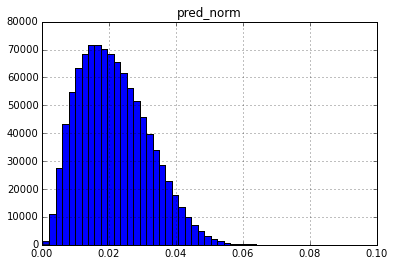

In [237]:
evals.hist(bins=50)

In [81]:
cf_rec_songs.shape

(412067, 5)

In [98]:
evals.shape

(1019318, 2)

In [99]:
cf_rec_songs.head()

,user_id,song_id,conf,track_id,cbrec
0,27b3ada29b6fbc58cc0be1beeee5c161490525ba,SOAUWYT12A81C206F1,0.138705,TRGXQES128F42BA5EB,TRTBIEH128F427C13C
1,6a8e16ac4eaa5ee1728e1b60922999b270c17fdf,SOOHWRZ12AC468BA59,0.074418,TROYOZD12903CEE24F,TRAMNJB128F92EFDC7
2,6ed926e5e561ddbbe64e2035a6c7d0ee5577e14c,SOPPROJ12AB0184E18,0.049008,TRDFZTB12903CF1CBD,TRLGMFJ128F4217DBE
3,ca0925c9fdcbf37a01f1a78b68cee569d1bf7022,None,NaN,None,TRHKJNX12903CEFCDF
4,01af5e2e5171efb50f0ddecfd7b89fc9cf0adb21,SOEOPHK12A58A78ECF,0.056607,TRVJJWW12903CE67AA,TRXCWFL128F9325F6F


In [129]:
cb_rec_track_dict = {k: v for k, v in zip(cf_rec_songs.user_id, cf_rec_songs.cbrec)}

In [238]:
evals['track_id'] = evals.user_id.apply(lambda x: cb_rec_track_dict.get(x, None))

In [239]:
# clean the final predictions 
df = pd.merge(cf_rec_songs, evals, on="user_id")

df.drop(["track_id_y", "song_id"], axis=1, inplace=True)

df['final_pred'] = df['conf']

df.loc[df.conf < 0.1, 'final_pred'] = df.loc[df.conf < 0.1, "pred_norm"]

df.loc[(df.pred_norm > df.conf) & (df.conf < 0.1), "final_pred"] = df.loc[(df.pred_norm > df.conf) & (df.conf < 0.1), "pred_norm"]

df.loc[df.conf.isnull(), "final_pred"] = df.loc[df.conf.isnull(), "pred_norm"]

In [240]:
df['final_tid'] = df.track_id_x

df.loc[df.conf < 0.1, 'final_tid'] = df.loc[df.conf < 0.1, "cbrec"]

df.loc[(df.pred_norm > df.conf) & (df.conf < 0.1), "final_tid"] = df.loc[(df.pred_norm > df.conf) & (df.conf < 0.1), "cbrec"]

df.loc[df.conf.isnull(), "final_tid"] = df.loc[df.conf.isnull(), "cbrec"]

final = df

In [241]:
final.head()

,user_id,conf,track_id_x,cbrec,pred_norm,final_pred,final_tid
0,27b3ada29b6fbc58cc0be1beeee5c161490525ba,0.138705,TRGXQES128F42BA5EB,TRTBIEH128F427C13C,0.022759,0.138705,TRGXQES128F42BA5EB
1,6a8e16ac4eaa5ee1728e1b60922999b270c17fdf,0.074418,TROYOZD12903CEE24F,TRAMNJB128F92EFDC7,0.021551,0.021551,TRAMNJB128F92EFDC7
2,6ed926e5e561ddbbe64e2035a6c7d0ee5577e14c,0.049008,TRDFZTB12903CF1CBD,TRLGMFJ128F4217DBE,0.027616,0.027616,TRLGMFJ128F4217DBE
3,ca0925c9fdcbf37a01f1a78b68cee569d1bf7022,NaN,None,TRHKJNX12903CEFCDF,0.038102,0.038102,TRHKJNX12903CEFCDF
4,01af5e2e5171efb50f0ddecfd7b89fc9cf0adb21,0.056607,TRVJJWW12903CE67AA,TRXCWFL128F9325F6F,0.013804,0.013804,TRXCWFL128F9325F6F


In [244]:
df_normed['track_id'] = df_normed.song_id.apply(get_single_tid)

In [245]:
df_normed.columns = ["user_id", "song_id", "play_count", "play_sum", "pc_norm", "track_id"]

In [246]:
final_merge = pd.merge(final, df_normed, 
                       left_on=["user_id", "final_tid"], 
                       right_on=["user_id", "track_id"],
                       how="left")

In [247]:
print(final.shape, df_normed.shape)

((412067, 7), (48373586, 6))


In [248]:
final_merge

,user_id,conf,track_id_x,cbrec,pred_norm,final_pred,final_tid,song_id,play_count,play_sum,pc_norm,track_id
0,27b3ada29b6fbc58cc0be1beeee5c161490525ba,0.138705,TRGXQES128F42BA5EB,TRTBIEH128F427C13C,0.022759,0.138705,TRGXQES128F42BA5EB,NaN,NaN,NaN,NaN,NaN
1,6a8e16ac4eaa5ee1728e1b60922999b270c17fdf,0.074418,TROYOZD12903CEE24F,TRAMNJB128F92EFDC7,0.021551,0.021551,TRAMNJB128F92EFDC7,NaN,NaN,NaN,NaN,NaN
2,6ed926e5e561ddbbe64e2035a6c7d0ee5577e14c,0.049008,TRDFZTB12903CF1CBD,TRLGMFJ128F4217DBE,0.027616,0.027616,TRLGMFJ128F4217DBE,NaN,NaN,NaN,NaN,NaN
3,ca0925c9fdcbf37a01f1a78b68cee569d1bf7022,NaN,None,TRHKJNX12903CEFCDF,0.038102,0.038102,TRHKJNX12903CEFCDF,NaN,NaN,NaN,NaN,NaN
4,01af5e2e5171efb50f0ddecfd7b89fc9cf0adb21,0.056607,TRVJJWW12903CE67AA,TRXCWFL128F9325F6F,0.013804,0.013804,TRXCWFL128F9325F6F,NaN,NaN,NaN,NaN,NaN
5,0ebbc1f2391a69966f029899d0f7929936685fd7,0.051311,TRHSGXW12903CE895F,TRLMZAU128F425045A,0.004063,0.004063,TRLMZAU128F425045A,NaN,NaN,NaN,NaN,NaN
6,f1e97499ac227a34407038bb55426e262bd3ad70,0.134716,TRDJWWE128F4255A4D,TRSJPWY128F9302565,0.025422,0.134716,TRDJWWE128F4255A4D,NaN,NaN,NaN,NaN,NaN
7,5786b71658878d3c7ac2200b7f4e628cf8fa80fa,0.093374,TRBKMRO128F935877F,TRHHMLX12903CB503B,0.008078,0.008078,TRHHMLX12903CB503B,NaN,NaN,NaN,NaN,NaN
8,208e0cc46d08efb53676825dccbb31ed2fb10fa9,0.288701,TRYVFOB128F9333BAA,TRHLRXZ128F149F06B,0.015949,0.288701,TRYVFOB128F9333BAA,NaN,NaN,NaN,NaN,NaN
9,4488e641b752b1f8b6bade8df4d46d8b6d147706,0.050872,TRTEHXL128F931687B,TRTPCAQ128F425D53B,0.040862,0.040862,TRTPCAQ128F425D53B,NaN,NaN,NaN,NaN,NaN


In [249]:
final_merge.loc[final_merge.pc_norm.isnull(), "pc_norm"] = 0

In [250]:
np.sqrt(((final_merge.final_pred - final_merge.pc_norm) ** 2).mean())

0.13765872200458884

In [258]:
final_merge.loc[final_merge.final_tid == final_merge.cbrec].shape

(288171, 12)

In [273]:
rands = np.array([np.random.uniform(0, 1) for i in range(final_merge.shape[0])])

In [274]:
np.sqrt(((rands - final_merge.pc_norm) ** 2).mean())

0.57699147977290288